In [5]:
import IPython
import json
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler

sys.path.append("../../")
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.calc.conv import *

from didgelab.evo.nuevolution import Genome, LossFunction, Nuevolution
from didgelab.evo.nuevolution import GeoGenome

from didgelab.util.didge_visualizer import DidgeVisualizer


In [27]:
!ls ../../../

README.md        evolutions       src
assets           saved_evolutions


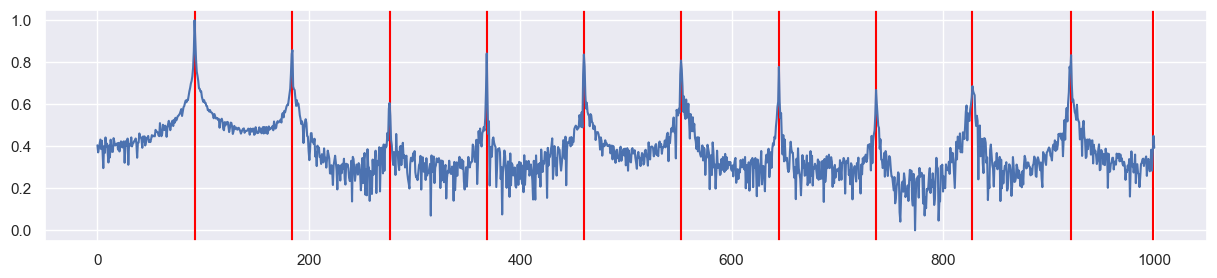

In [15]:
# analyze existing tamaki
infile = "../../../assets/didge-database/wav_short/4.wav"
fft_freq, fft = do_fft(infile)
fft = np.log2(fft)
fft -= fft.min()
fft /= fft.max()


peaks, indizes = get_peaks(fft_freq, fft, return_indizes=True)
impedances = fft[indizes]
for peak in peaks:
    plt.axvline(peak, 0, 1, c="red")

plt.plot(fft_freq, fft)


In [16]:
harmonic_series = [peaks[0]*i for i in range(1, len(peaks)+1)]
diff = harmonic_series - peaks
diffdf = {"measured_peaks": peaks, "harmonic_peaks": harmonic_series, "diff": diff}
pd.DataFrame(diffdf).round(2)

,measured_peaks,harmonic_peaks,diff
0,91.91,91.91,0.00
1,184.52,183.83,-0.70
2,276.44,275.74,-0.70
3,368.35,367.66,-0.70
4,460.27,459.57,-0.70
5,552.18,551.48,-0.70
6,644.79,643.40,-1.39
7,736.70,735.31,-1.39
8,827.92,827.23,-0.70
9,921.23,919.14,-2.09


In [17]:
peak_manipulated = peaks.copy()
peak_manipulated[4] -= 20
peak_manipulated[5] += 20
reference = {"impedance": impedances, "freq": peak_manipulated}
reference = pd.DataFrame(reference)
reference["harmonic_series"] = [i*peaks[0] for i in range(1, len(reference)+1)]
reference["diff"] = reference.harmonic_series - reference.freq
reference

,impedance,freq,harmonic_series,diff
0,1.000000,91.914005,91.914005,0.000000
1,0.857665,184.524328,183.828009,-0.696318
2,0.606621,276.438332,275.742014,-0.696318
3,0.842072,368.352337,367.656019,-0.696318
4,0.837390,440.266342,459.570024,19.303682
5,0.808493,572.180346,551.484028,-20.696318
6,0.778010,644.790669,643.398033,-1.392636
7,0.668187,736.704674,735.312038,-1.392636
8,0.686460,827.922361,827.226042,-0.696318
9,0.834084,921.229002,919.140047,-2.088955


In [13]:
reference

NameError: name 'reference' is not defined

459.570025

In [44]:
json.dumps(reference.to_dict())

'{"impedance": {"0": 1.0, "1": 0.8576649663048393, "2": 0.6066206728881713, "3": 0.8420721962421757, "4": 0.8373902860195547, "5": 0.8084926830620255, "6": 0.7780097302125277, "7": 0.6681873008986587, "8": 0.6864601376736074, "9": 0.8340840526459629, "10": 0.44992931052124463}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "2": 276.4383323178693, "3": 368.3523370180173, "4": 440.2663417181653, "5": 572.1803464183132, "6": 644.7906693358866, "7": 736.7046740360346, "8": 827.9223605187572, "9": 921.2290016537559, "10": 999.2166420053966}, "harmonic_series": {"0": 91.91400470014798, "1": 183.82800940029597, "2": 275.74201410044395, "3": 367.65601880059194, "4": 459.5700235007399, "5": 551.4840282008879, "6": 643.3980329010359, "7": 735.3120376011839, "8": 827.2260423013319, "9": 919.1400470014798, "10": 1011.0540517016278}, "diff": {"0": 0.0, "1": -0.6963182174253575, "2": -0.6963182174253575, "3": -0.6963182174253575, "4": 19.303681782574643, "5": -20.6963182174253, "6": -1.3

<AxesSubplot: xlabel='x', ylabel='y'>

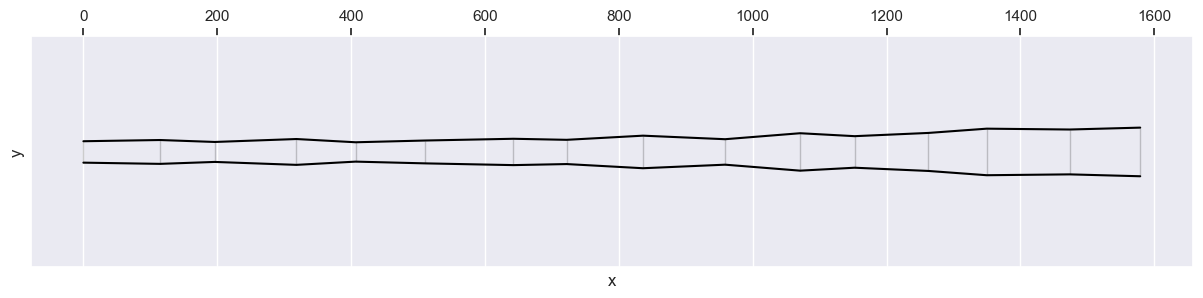

In [6]:
class BlackEucaShape(GeoGenome):
    
    def add_param(self, name, minval, maxval):
        self.named_params[name] = {
            "index": len(self.named_params),
            "min": minval,
            "max": maxval
        }

    def get_value(self, name):
        p = self.named_params[name]
        v = self.genome[p["index"]]
        v = v*(p["max"]-p["min"]) + p["min"]
        return v

    def __init__(self):
        
        self.named_params = {}

        self.d1=32
        self.n_segments = 15
        
        self.add_param("length", 1520, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,2)
        
        for i in range(self.n_segments-1):
            self.add_param(f"delta_x{i}", -20, 20)
            self.add_param(f"delta_y{i}", 0.8, 1.2)
        
        GeoGenome.__init__(self, n_genes = len(self.named_params))

    def genome2geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
    
        y= np.arange(self.n_segments+1)/self.n_segments
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        for i in range(1, self.n_segments-1):
            delta_x = self.get_value(f"delta_x{i}")
            delta_y = self.get_value(f"delta_y{i}")
            y[i] *= delta_y
            x[i] += delta_x
            x = sorted(x)
            
        geo = list(zip(x,y))
        
        return Geo(geo)

np.random.seed
genome = BlackEucaShape()
DidgeVisualizer.vis_didge(genome.genome2geo())

In [18]:
class Tamaki3Loss(LossFunction):

    def __init__(self):
        self.reference = '{"impedance": {"0": 1.0, "1": 0.8576649663048393, "2": 0.6066206728881713, "3": 0.8420721962421757, "4": 0.8373902860195547, "5": 0.8084926830620255, "6": 0.7780097302125277, "7": 0.6681873008986587, "8": 0.6864601376736074, "9": 0.8340840526459629, "10": 0.44992931052124463}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "2": 276.4383323178693, "3": 368.3523370180173, "4": 440.2663417181653, "5": 572.1803464183132, "6": 644.7906693358866, "7": 736.7046740360346, "8": 827.9223605187572, "9": 921.2290016537559, "10": 999.2166420053966}, "harmonic_series": {"0": 91.91400470014798, "1": 183.82800940029597, "2": 275.74201410044395, "3": 367.65601880059194, "4": 459.5700235007399, "5": 551.4840282008879, "6": 643.3980329010359, "7": 735.3120376011839, "8": 827.2260423013319, "9": 919.1400470014798, "10": 1011.0540517016278}, "diff": {"0": 0.0, "1": -0.6963182174253575, "2": -0.6963182174253575, "3": -0.6963182174253575, "4": 19.303681782574643, "5": -20.6963182174253, "6": -1.392636434850715, "7": -1.392636434850715, "8": -0.6963182174253006, "9": -2.0889546522760156, "10": 11.837409696231248}}'
        self.target_peaks = [4,5]
        self.reference = pd.DataFrame(json.loads(self.reference))        
        self.reference["impedance_normalized"] = self.reference.impedance / self.reference.impedance.max()
        self.reference["logfreq"] = np.log2(self.reference.freq)
        
    def loss(self, genome, context=None):
        freqs = get_log_simulation_frequencies(1, 1000, 5)
        segments = create_segments(genome.genome2geo())
        impedances = compute_impedance(segments, freqs)
        peaks = get_notes(freqs, impedances)

        peaks["logfreq"] = np.log2(peaks.freq)
        peaks["impedance_normalized"] = peaks.impedance / peaks.impedance.max()
        
        tuning_loss = []
        imp_loss = []
        wobble_freq_loss = []
        wobble_vol_loss = []

        # i_harmonic = 1

        # difference to target peaks loss
        base_freq = peaks.freq.iloc[0]
        for ix, peak in peaks.iterrows():
            mini = np.argmin([np.abs(peak.logfreq-f) for f in self.reference.logfreq])
            
            tl = np.abs(peak.logfreq-self.reference.logfreq[mini])
            il = np.abs(peak.impedance_normalized - self.reference.impedance_normalized[mini])
            tuning_loss.append(tl)
            imp_loss.append(il)
        
        # wobble freq losses
        for target_peak in self.target_peaks:
            f_target = self.reference.logfreq[target_peak]
            closest_peak_i = np.argmin(np.abs(f_target-peaks.logfreq))
            
            tuning_diff = np.abs(peaks.logfreq[closest_peak_i]-f_target)
            wobble_freq_loss.append(tuning_diff)

            imp_target = self.reference.rel_imp[target_peak]
            imp_diff = np.abs(peak.impedance - imp_target)
            wobble_vol_loss.append(imp_diff)

        fundamental_loss = tuning_loss[0]*10
        tuning_loss = np.sum(tuning_loss) / len(tuning_loss)
        imp_loss = np.sum(imp_loss) / len(imp_loss)
        wobble_freq_loss = np.sum(wobble_freq_loss) / len(wobble_freq_loss)
        wobble_vol_loss = np.sum(wobble_vol_loss) / len(wobble_vol_loss)

        losses =  {
            "fundamental_loss": 5*fundamental_loss,
            "tuning_loss": 10*tuning_loss,
            "imp_loss": 10*imp_loss,
            "wobble_freq_loss": 30*wobble_freq_loss,
            "wobble_vol_loss": 8*wobble_vol_loss
        }

        losses["total"] = np.sum(list(losses.values()))
        return losses
    

Tamaki3Loss().loss(genome)

AttributeError: 'DataFrame' object has no attribute 'rel_imp'

In [22]:
len(harmonic_series)

13